# Perkenalan

Nama: Aumedi Wibisana Pratama Subagyo \
Batch: RMT-025

Dataset yang digunakan pada notebook ini mengacu ke tahun 2005. Isinya adalah sejumlah profil individu, anggaran kartu kredit mereka, informasi tagihan, jumlah terbayar serta informasi mengenai apakah pembayaran mereka ditunda atau tidak. Tagihan ini diterbitkan tiap bulan dari bulan April hingga September 2005. Tidak semua entry membayar tepat waktu (ada yang menunda). Model machine di sini dibuat untuk memprediksi apakah sebuah individu, dengan profil data yang diberikan, akan "default payment" bulan depan atau tidak. Model classifier yang disetup akan ada tiga, yakni *Logistic Regression*, *KNN*, dan *SVM*. Namun hanya akan ada satu yang dipilih berdasarkan performanya setelah dituning hyperparameternya.

# QuerySQL

Query SQL yang diterapkan untuk memperoleh data dari Google Console Cloud sesuai instruksi adalah sebagai berikut:

```sql
SELECT
    limit_balance,
    CAST(sex AS INT64) AS sex,
    CAST(education_level AS INT64) AS education_level,
    CAST(marital_status AS INT64) AS marital_status,
    age,
    pay_0,
    pay_2,
    pay_3,
    pay_4,
    CAST(pay_5 AS FLOAT64) AS pay_5,
    CAST(pay_6 AS FLOAT64) AS pay_6,
    bill_amt_1,
    bill_amt_2,
    bill_amt_3,
    bill_amt_4,
    bill_amt_5,
    bill_amt_6,
    pay_amt_1,
    pay_amt_2,
    pay_amt_3,
    pay_amt_4,
    pay_amt_5,
    pay_amt_6,
    CAST(default_payment_next_month AS INT64) AS default_payment_next_month
  FROM `bigquery-public-data.ml_datasets.credit_card_default`
  LIMIT 50000
  """
```

# Import Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
from google.colab import auth
from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV

# Data Loading

In [ ]:
auth.authenticate_user()

project_id = "buddysession25oktober2023"
client = bigquery.Client(project=project_id)

# put your query here
query = """

  SELECT
    limit_balance,
    CAST(sex AS INT64) AS sex,
    CAST(education_level AS INT64) AS education_level,
    CAST(marital_status AS INT64) AS marital_status,
    age,
    pay_0,
    pay_2,
    pay_3,
    pay_4,
    CAST(pay_5 AS FLOAT64) AS pay_5,
    CAST(pay_6 AS FLOAT64) AS pay_6,
    bill_amt_1,
    bill_amt_2,
    bill_amt_3,
    bill_amt_4,
    bill_amt_5,
    bill_amt_6,
    pay_amt_1,
    pay_amt_2,
    pay_amt_3,
    pay_amt_4,
    pay_amt_5,
    pay_amt_6,
    CAST(default_payment_next_month AS INT64) AS default_payment_next_month
  FROM `bigquery-public-data.ml_datasets.credit_card_default`
  LIMIT 50000
  """

# Set up the query
df = client.query(query).to_dataframe()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   Int64  
 2   education_level             2965 non-null   Int64  
 3   marital_status              2965 non-null   Int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

In [ ]:
df.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0


In [ ]:
df.tail()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,...,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


In [ ]:
df.to_csv('P1G5_Set_1_aumedi_wibisana.csv', index=False)

# Exploratory Data Analysis

Cek korelasi data-data terhadap `default_payment_next_month`

In [ ]:
dfCorr = df.corr()
dfCorr['default_payment_next_month']

limit_balance                -0.161909
sex                          -0.021765
education_level               0.044926
marital_status               -0.025998
age                           0.016905
pay_0                         0.356963
pay_2                         0.288813
pay_3                         0.275758
pay_4                         0.255805
pay_5                         0.253319
pay_6                         0.237170
bill_amt_1                   -0.005961
bill_amt_2                    0.000877
bill_amt_3                   -0.001075
bill_amt_4                   -0.004718
bill_amt_5                    0.005930
bill_amt_6                    0.006116
pay_amt_1                    -0.066163
pay_amt_2                    -0.059265
pay_amt_3                    -0.090248
pay_amt_4                    -0.053684
pay_amt_5                    -0.066159
pay_amt_6                    -0.066966
default_payment_next_month    1.000000
Name: default_payment_next_month, dtype: float64

Nilai korelasi `pay_0`, `pay_2`, `pay_3`, `pay_4`, `pay_5`, dan `pay_6` terhadap `default_payment_next_month` secara berturut turut adalah 0,356; 0,288; 0,275; 0,255; 0,253; dan 0,237. Nilai-nilai tersebut setidaknya 10 kali lebih besar dibandingkan magintude nilai-nilai korelasi lainnya, dengan pengecualian pada `limit_balance`.

Cek distribusi `bill_amt_2` dan `pay_amt_2`

<Axes: xlabel='bill_amt_2', ylabel='Count'>

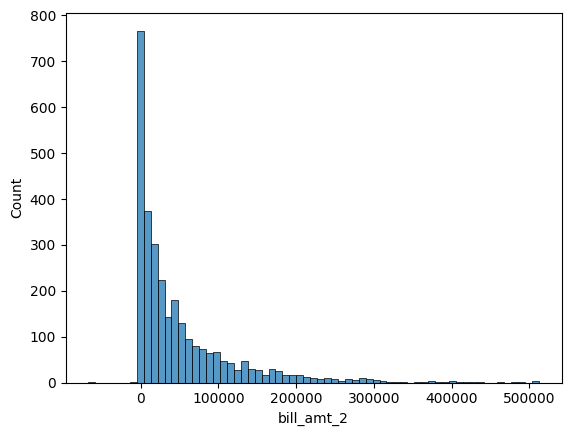

In [ ]:
sns.histplot(data=df, x='bill_amt_2')

<Axes: xlabel='pay_amt_2', ylabel='Count'>

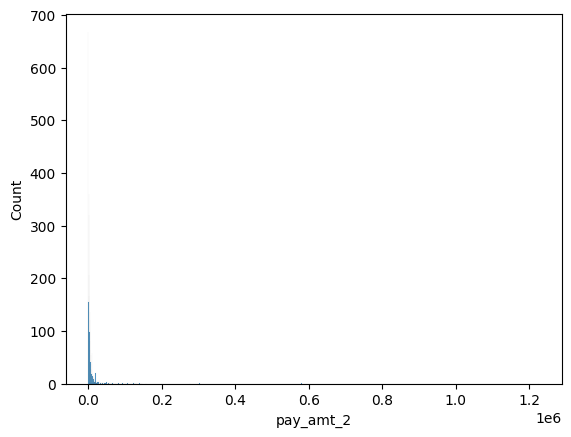

In [ ]:
sns.histplot(data=df, x='pay_amt_2')

`bill_amt_...` dan `pay_amt_...` menunjukkan jumlah tagihan dan jumlah yang terbayarkan secara berturut-turut. Angka 1 pada `bill_amt_1` dan `pay_amt_1` mewakili bulan September 2005, sedangkan angka 6 mewakili bulan April 2005. Sebagian besar entrynya memiliki nilai nol. Kolom-kolom `bill_amt_2` hingga `bill_amt_6` memiliki nilai negatif. Nilai tagihan tidak mungkin negatif sehingga diasumsikan nilai-nilai negatif tersebut merupakan sebuah kesalahan. Handlingnya akan dilakukan dengan pemutlakan.

In [ ]:
# Cek nilai maksimum kolom kolom bill_amt

print('Max bill_amt_1:', df['bill_amt_1'].max())
print('Max bill_amt_2:', df['bill_amt_2'].max())
print('Max bill_amt_3:', df['bill_amt_3'].max())
print('Max bill_amt_4:', df['bill_amt_4'].max())
print('Max bill_amt_5:', df['bill_amt_5'].max())
print('Max bill_amt_6:', df['bill_amt_6'].max())

Max bill_amt_1: 613860.0
Max bill_amt_2: 512650.0
Max bill_amt_3: 578971.0
Max bill_amt_4: 488808.0
Max bill_amt_5: 441981.0
Max bill_amt_6: 436172.0


In [ ]:
# Cek nilai maksimum kolom kolom pay_amt

print('Max pay_amt_1:', df['pay_amt_1'].max())
print('Max pay_amt_2:', df['pay_amt_2'].max())
print('Max pay_amt_3:', df['pay_amt_3'].max())
print('Max pay_amt_4:', df['pay_amt_4'].max())
print('Max pay_amt_5:', df['pay_amt_5'].max())
print('Max pay_amt_6:', df['pay_amt_6'].max())

Max pay_amt_1: 493358.0
Max pay_amt_2: 1227082.0
Max pay_amt_3: 199209.0
Max pay_amt_4: 202076.0
Max pay_amt_5: 388071.0
Max pay_amt_6: 403500.0


<Axes: xlabel='limit_balance', ylabel='Count'>

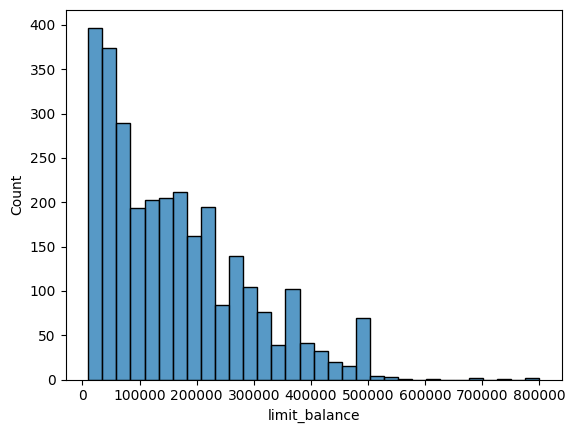

In [ ]:
# Cek distribusi limit_balance

sns.histplot(data = df, x = 'limit_balance')

Distribusi `limit_balance` cenderung skew ke kiri

<Axes: xlabel='age', ylabel='Count'>

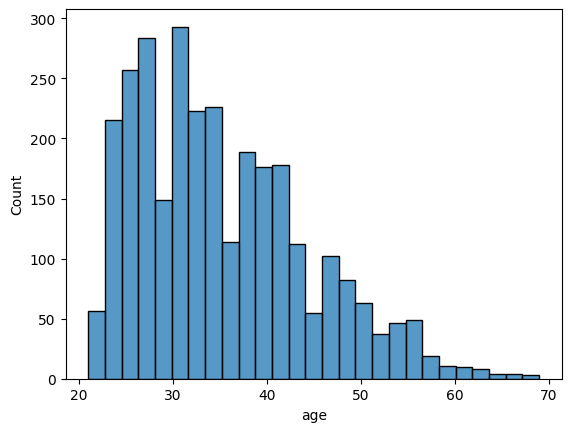

In [ ]:
# Cek distribusi usia

sns.histplot(data=df, x='age')

In [ ]:
print('Skewness age:', df['age'].skew())

Skewness age: 0.7728871800647298


Distribusi `age` juga terlihat skew ke kiri tapi tidak sebesar `limit_balance`. Umur 30 muncul paling banyak dalam dataset. Berdasarkan skewnessnya, distribusi `age` moderately skewed.

In [ ]:
# Cek jumlah pria dan wanita

dfMale = df[(df['sex'] == 1)]
dfFemale = df[(df['sex'] == 2)]

print('Number of males:', len(dfMale))
print('Number of females:', len(dfFemale))

Number of males: 1163
Number of females: 1802


Entry data perempuan pada dataset lebih banyak dibanding entry data laki-laki.

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


<Axes: xlabel='marital_status', ylabel='Count'>

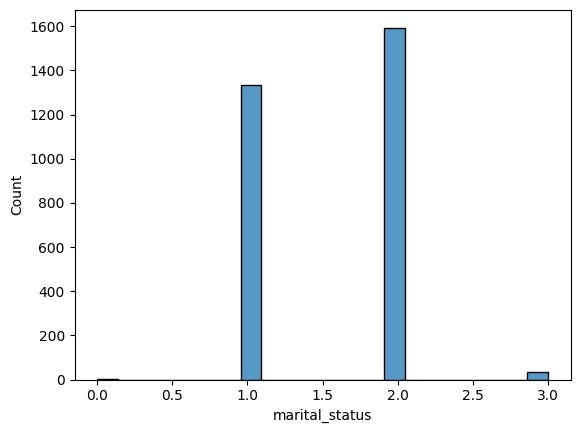

In [ ]:
# Cek jumlah status pernikahan

sns.histplot(data = df, x = 'marital_status')

Dataset didominasi oleh entry yang status pernikahannya single.

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


<Axes: xlabel='education_level', ylabel='Count'>

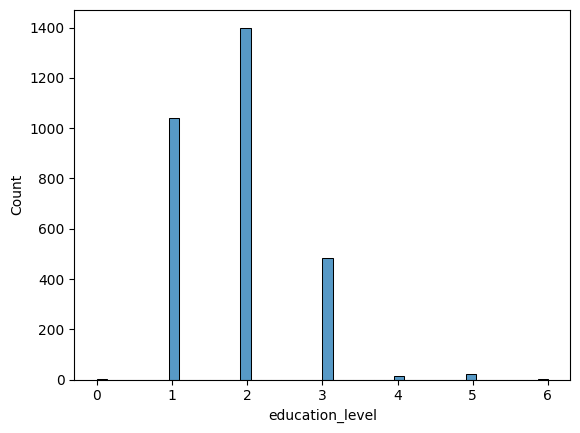

In [ ]:
# Cek jumlah status pendidikan

sns.histplot(data = df, x = 'education_level')

Sebagian besar entry memiliki edukasi tingkat universitas.

# Feature Engineering

Label dataset ini adalah `default_payment_next_month`. Pertama-tama mereka dipisahkan terlebih dahulu dengan keseluruhan data.

In [ ]:
# Pemisahan feature dan label dari dataset

x = df.drop(['default_payment_next_month'], axis=1)
y = df[['default_payment_next_month']]
x.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0


Splitting data menjadi data train dan test dilakukan dengan rasio 70:30.

In [ ]:
# Split data menjadi data train dan test

xTrain, xTest, yTrain, yTest = train_test_split(x,y, test_size=0.3, random_state=21)

Kolom `sex`, `education_level`, `marital_status`, `pay_0`, `pay_1`, `pay_2`, `pay_3`, `pay_4`, `pay_5`, dan `pay_6` merupakan kolom kategorik yang telah terenkoding sehingga enkoding tidak akan dilakukan. Kolom-kolom sisanya adalah kolom numerik yang akan discale. Setiap kolom numerik akan discale dengan RobustScaler karena banyaknya outlier yang dijumpai pada dataset. Namun kolom `age` akan discale dengan MinMaxScaler karena distribusinya moderately skewed. Untuk scaling, kolom-kolom kategorik feature train dan test akan dipisah.

In [ ]:
# Split feature kategorik dan numerik

xTrainNum = xTrain.drop(['sex', 'education_level', 'marital_status', 'pay_0',
                         'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'], axis=1)
xTestNum = xTest.drop(['sex', 'education_level', 'marital_status', 'pay_0',
                         'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'], axis=1)
xTrainCat = xTrain.drop(['limit_balance', 'age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3',
                         'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2',
                         'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'], axis=1)
xTestCat = xTest.drop(['limit_balance', 'age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3',
                         'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2',
                         'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'], axis=1)

In [ ]:
xTrainCat

,sex,education_level,marital_status,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
1422,2,2,1,2.0,2.0,2.0,2.0,0.0,0.0
1696,2,2,2,-2.0,-2.0,-1.0,0.0,0.0,-1.0
2295,2,1,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
653,2,2,1,0.0,0.0,0.0,0.0,0.0,0.0
1670,1,2,2,0.0,0.0,0.0,0.0,0.0,-2.0
...,...,...,...,...,...,...,...,...,...
2416,2,2,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
48,1,1,2,0.0,0.0,0.0,0.0,0.0,0.0
772,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0
1848,2,2,1,0.0,0.0,2.0,2.0,2.0,2.0


In [ ]:
xTrainNum

,limit_balance,age,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
1422,150000.0,37.0,100390.0,108784.0,110405.0,106317.0,30906.0,31457.0,11600.0,4800.0,0.0,1240.0,1200.0,1200.0
1696,260000.0,29.0,-5.0,-5.0,9571.0,7235.0,0.0,197.0,0.0,9576.0,29.0,0.0,197.0,568.0
2295,430000.0,38.0,590.0,590.0,590.0,590.0,590.0,590.0,590.0,590.0,590.0,590.0,590.0,590.0
653,460000.0,40.0,133102.0,126956.0,126758.0,121857.0,122830.0,90219.0,5015.0,5032.0,4407.0,4040.0,3001.0,3109.0
1670,10000.0,23.0,2068.0,6000.0,6457.0,6177.0,0.0,0.0,4400.0,1000.0,500.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416,340000.0,27.0,14745.0,9318.0,4794.0,7819.0,332.0,16516.0,9318.0,5343.0,7819.0,332.0,16516.0,5000.0
48,310000.0,45.0,313268.0,278821.0,283847.0,290135.0,293350.0,300623.0,10010.0,11500.0,11015.0,11000.0,12000.0,23035.0
772,120000.0,27.0,15234.0,8247.0,9624.0,20129.0,10388.0,13316.0,1137.0,1514.0,1069.0,278.0,3000.0,0.0
1848,60000.0,31.0,37549.0,40603.0,39676.0,42407.0,41428.0,45576.0,4000.0,0.0,3700.0,0.0,5000.0,2000.0


In [ ]:
# Handling nilai negatif di bill_amt_2 hingga bill_amt_6

xTrainNum['bill_amt_2'] = xTrainNum['bill_amt_2'].abs()
xTrainNum['bill_amt_3'] = xTrainNum['bill_amt_3'].abs()
xTrainNum['bill_amt_4'] = xTrainNum['bill_amt_4'].abs()
xTrainNum['bill_amt_5'] = xTrainNum['bill_amt_5'].abs()
xTrainNum['bill_amt_6'] = xTrainNum['bill_amt_6'].abs()

xTestNum['bill_amt_2'] = xTestNum['bill_amt_2'].abs()
xTestNum['bill_amt_3'] = xTestNum['bill_amt_3'].abs()
xTestNum['bill_amt_4'] = xTestNum['bill_amt_4'].abs()
xTestNum['bill_amt_5'] = xTestNum['bill_amt_5'].abs()
xTestNum['bill_amt_6'] = xTestNum['bill_amt_6'].abs()

In [ ]:
# Scaling feature-feature numerik
# Pisahkan age dengan feature-feature numerik lainnya

xTrainNumAge = xTrainNum[['age']]
xTestNumAge = xTestNum[['age']]
xTrainNumNoAge = xTrainNum.drop(['age'], axis=1)
xTestNumNoAge = xTestNum.drop(['age'], axis=1)

minMaxScale = MinMaxScaler()
robustScale = RobustScaler()

# Scaling feature-feature tanpa age dengan RobustScaler
robustScale.fit(xTrainNumNoAge)

xTrainNumNoAgeScled = robustScale.transform(xTrainNumNoAge)
xTestNumNoAgeScled = robustScale.transform(xTestNumNoAge)

# Scaling feature age dengan MinMaxScaler
minMaxScale.fit(xTrainNumAge)

xTrainNumAgeScled = minMaxScale.transform(xTrainNumAge)
xTestNumAgeScled = minMaxScale.transform(xTestNumAge)

In [ ]:
# Pembuatan dataframe baru untuk feature-feature yang telah discale

origTrainIndex = xTrainCat.index.tolist() # Menyimpan index-index setiap entry sebelum discaling untuk
                                          # dikemablikan ke dataframe baru setelah scaling

origTestIndex = xTestCat.index.tolist()

xTrainNumNoAgeScledDF = pd.DataFrame(xTrainNumNoAgeScled, columns=['limit_balance', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3',
                         'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2',
                         'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'], index = origTrainIndex)

xTrainNumAgeScledDF = pd.DataFrame(xTrainNumAgeScled, columns=['age'], index = origTrainIndex)

xTestNumNoAgeScledDF = pd.DataFrame(xTestNumNoAgeScled, columns=['limit_balance', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3',
                         'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2',
                         'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'], index = origTestIndex)

xTestNumAgeScledDF = pd.DataFrame(xTestNumAgeScled, columns=['age'], index = origTestIndex)

# Penggabungan dataframe train dan test numerik menjadi satu
xTrainNumScl = pd.concat([xTrainNumNoAgeScledDF, xTrainNumAgeScledDF], axis=1)
xTestNumScl = pd.concat([xTestNumNoAgeScledDF, xTestNumAgeScledDF], axis=1)

xTestNumScl

,limit_balance,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,age
136,2.000000,1.356196,1.270280,1.252414,1.390702,3.363963,3.249738,0.448284,0.469626,3.846841,26.066225,2.304986,4.728682,0.479167
1490,-0.611111,0.012676,0.068355,0.104976,0.134738,0.185618,0.225575,0.250373,-0.259608,-0.483803,-0.140927,0.126593,-0.284238,0.145833
991,-0.333333,-0.320611,-0.213412,-0.267885,-0.199203,-0.290778,-0.253956,0.988812,0.259112,0.762318,0.018543,1.231302,-0.025840,0.041667
1436,-0.666667,-0.276487,-0.249325,-0.243246,-0.205101,-0.192233,-0.178038,-0.247887,-0.524424,-0.185925,-0.158940,-0.326593,-0.310078,0.062500
2003,-0.500000,0.181800,0.218241,0.277834,0.389775,0.440284,0.457247,-0.048981,-0.028515,0.530470,-0.423841,-0.049584,-0.180879,0.645833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,-0.611111,0.020561,0.053728,0.100455,0.105967,0.129194,0.151978,-0.103680,-0.090007,-0.070249,-0.211921,-0.143490,0.368992,0.187500
535,-0.500000,-0.085106,-0.002304,-0.009950,-0.040837,-0.230389,-0.218490,0.696917,-0.102901,0.012660,-0.291391,-0.326593,-0.310078,0.062500
1644,-0.500000,-0.363864,-0.361641,-0.152388,-0.104403,-0.047441,-0.065987,-0.247887,2.706918,-0.111456,0.370861,-0.311634,0.077519,0.708333
2034,0.888889,-0.235738,-0.266604,-0.250439,-0.235976,-0.195976,-0.302947,-0.094232,1.265063,1.259526,2.061722,0.563712,1.252196,0.145833


In [ ]:
# Penggabungan dataframe train dan test numerik dan kategorik

xTrainFinal = pd.concat([xTrainNumScl, xTrainCat], axis=1)
xTestFinal = pd.concat([xTestNumScl, xTestCat], axis=1)

In [ ]:
xTrainFinal

,limit_balance,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,...,age,sex,education_level,marital_status,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
1422,0.055556,1.176605,1.342564,1.484147,1.550381,0.239998,0.257408,2.337892,0.665758,-0.483803,...,0.333333,2,2,1,2.0,2.0,2.0,2.0,0.0,0.0
1696,0.666667,-0.384845,-0.373870,-0.210556,-0.231301,-0.385256,-0.373597,-0.546246,1.849988,-0.476604,...,0.166667,2,2,2,-2.0,-2.0,-1.0,0.0,0.0,-1.0
2295,1.611111,-0.375591,-0.364639,-0.361499,-0.350791,-0.373320,-0.365664,-0.399552,-0.378130,-0.337346,...,0.354167,2,1,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
653,1.777778,1.685377,1.629302,1.758990,1.829819,2.099698,1.443561,0.700646,0.723283,0.610153,...,0.395833,2,2,1,0.0,0.0,0.0,0.0,0.0,0.0
1670,-0.722222,-0.352604,-0.279274,-0.262893,-0.250326,-0.385256,-0.377574,0.547737,-0.276469,-0.359687,...,0.041667,1,2,2,0.0,0.0,0.0,0.0,0.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416,1.111111,-0.155437,-0.226919,-0.290843,-0.220800,-0.378539,-0.044187,1.770512,0.800397,1.457118,...,0.125000,2,2,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
48,0.944444,4.487511,4.025594,4.399163,4.855776,5.549459,5.690715,1.942566,2.327052,2.250465,...,0.500000,1,1,2,0.0,0.0,0.0,0.0,0.0,0.0
772,-0.111111,-0.147832,-0.243819,-0.209666,0.000557,-0.175098,-0.108781,-0.263550,-0.149021,-0.218444,...,0.125000,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0
1848,-0.444444,0.199235,0.266730,0.295414,0.401158,0.452867,0.542410,0.448284,-0.524424,0.434653,...,0.208333,2,2,1,0.0,0.0,2.0,2.0,2.0,2.0


In [ ]:
xTestFinal

,limit_balance,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,...,age,sex,education_level,marital_status,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
136,2.000000,1.356196,1.270280,1.252414,1.390702,3.363963,3.249738,0.448284,0.469626,3.846841,...,0.479167,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0
1490,-0.611111,0.012676,0.068355,0.104976,0.134738,0.185618,0.225575,0.250373,-0.259608,-0.483803,...,0.145833,1,3,2,1.0,2.0,2.0,2.0,0.0,0.0
991,-0.333333,-0.320611,-0.213412,-0.267885,-0.199203,-0.290778,-0.253956,0.988812,0.259112,0.762318,...,0.041667,2,2,2,0.0,0.0,0.0,0.0,0.0,-1.0
1436,-0.666667,-0.276487,-0.249325,-0.243246,-0.205101,-0.192233,-0.178038,-0.247887,-0.524424,-0.185925,...,0.062500,1,2,2,1.0,2.0,2.0,0.0,0.0,0.0
2003,-0.500000,0.181800,0.218241,0.277834,0.389775,0.440284,0.457247,-0.048981,-0.028515,0.530470,...,0.645833,1,3,1,2.0,2.0,2.0,2.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,-0.611111,0.020561,0.053728,0.100455,0.105967,0.129194,0.151978,-0.103680,-0.090007,-0.070249,...,0.187500,1,1,2,0.0,0.0,0.0,0.0,0.0,0.0
535,-0.500000,-0.085106,-0.002304,-0.009950,-0.040837,-0.230389,-0.218490,0.696917,-0.102901,0.012660,...,0.062500,1,2,2,0.0,0.0,0.0,0.0,0.0,0.0
1644,-0.500000,-0.363864,-0.361641,-0.152388,-0.104403,-0.047441,-0.065987,-0.247887,2.706918,-0.111456,...,0.708333,1,3,1,-1.0,-1.0,-1.0,0.0,0.0,0.0
2034,0.888889,-0.235738,-0.266604,-0.250439,-0.235976,-0.195976,-0.302947,-0.094232,1.265063,1.259526,...,0.145833,2,1,2,0.0,0.0,0.0,-1.0,-1.0,-2.0


Dengan demikian, fitur-fitur train dan test telah siap untuk difit oleh model. Pada notebook ini tidak dilakukan feature selection. Fitur-fitur yang ada dipakai semua, terutama seruntutan `pay_...`, `bill_amt_...`, dan `pay_amt_...`. Mereka merupakan tren pembayaran dan tagihan tiap bulan dari setiap entry. Pola mereka tentu esensial untuk membantu model memprediksi, dari data yang diberikan, apakah mereka akan membayar bulan depannya atau tidak.

# Model Definition

Bagian ini akan mensetup model-model yang akan digunakan: Logistic Regression, KNN, dan SVM.

In [ ]:
# Define Logistic Regression

logReg = LogisticRegression(penalty='l2', C=1.0, random_state=0)
logReg

LogisticRegression(random_state=0)

In [ ]:
# Define KNN

knn = KNeighborsClassifier(n_neighbors=36)
knn

KNeighborsClassifier(n_neighbors=36)

In [ ]:
# Define SVM dengan kernel rbf

svm = SVC(kernel='rbf', C=50, gamma=0.1)
svm

SVC(C=50, gamma=0.1)

# Model Training

Bagian ini adalah tempat training model-model.

## Training Logistic Regression

In [ ]:
# Training Logistic Regression pada data train

logReg.fit(xTrainFinal, yTrain)

print("LR Coefficient :", logReg.coef_)
print("LR Intercept   :", logReg.intercept_)

LR Coefficient : [[-0.12377818 -0.41229815  0.25200506  0.30833714 -0.6070796   0.3942101
   0.01914393 -0.0198767  -0.07262076 -0.05125103 -0.03212968 -0.04138191
  -0.03019768  0.7169212   0.17940795 -0.00897241 -0.102121    0.62671162
   0.05866936  0.04602496  0.01579701  0.19871731 -0.03456941]]
LR Intercept   : [-1.56238516]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Training KNN

In [ ]:
# Training KNN pada data train

knn.fit(xTrainFinal, yTrain)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=36)

## Training SVM

In [ ]:
# Training SVM pada data train

svm.fit(xTrainFinal, yTrain)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=50, gamma=0.1)

# Model Evaluation

Evaluasi model-model akan dilakukan di bagian ini. Model akan diterapkan untuk memprediksi terlebih dahulu. Hyperparameter tuning dengan RandomSearchCV akan dilakukan setelah evaluasi. Setelah itu model akan dievaluasi lagi dengan hyperparameter yang baru. Model yang memiliki performa terbaik akan disave dan dideploy.

## Logistic Regression Evaluation

In [ ]:
# Prediksi oleh Logistic Regression

yPredTrainLR = logReg.predict(xTrainFinal)
yPredTestLR = logReg.predict(xTestFinal)

In [ ]:
# Evaluasi model Logistic Regression dengan Classification Report

print('Train Log. Regression Report : \n', classification_report(yTrain, yPredTrainLR), '\n')
print('Test Log. Regression Report : \n', classification_report(yTest, yPredTestLR), '\n')

Train Log. Regression Report : 
               precision    recall  f1-score   support

         0.0       0.83      0.97      0.89      1612
         1.0       0.74      0.29      0.42       463

    accuracy                           0.82      2075
   macro avg       0.78      0.63      0.65      2075
weighted avg       0.81      0.82      0.79      2075
 

Test Log. Regression Report : 
               precision    recall  f1-score   support

         0.0       0.85      0.97      0.91       718
         1.0       0.71      0.26      0.38       172

    accuracy                           0.84       890
   macro avg       0.78      0.62      0.64       890
weighted avg       0.82      0.84      0.80       890
 



Model LR memiliki akurasi dan presisi yang cukup baik. Namun recall-nya dalam memprediksi entry yang akan `default_payment_next_month` buruk. Hasil ini berlaku untuk data train dan test. Sekarang akan dilakukan hyperparameter tuning untuk mencoba memperbaiki nilai recall. Parameter Logistic Regression yang akan dituning disini adalah `penalty`, `C`, dan `random_state`.

In [ ]:
# Define parameter-parameter RandomSearchCV untuk Logistic Regression

# Parameter-parameter di sini harus disesuaikan dengan parameter LR
paramsLR = {'penalty': ['l2'],
            'C': list(range(10, 160, 10)),
            'random_state':list(range(10, 40, 10))}
paramsLR

{'penalty': ['l2'],
 'C': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150],
 'random_state': [10, 20, 30]}

In [ ]:
# Training LR dengan RandomSearchCV

logRegRSCV = RandomizedSearchCV(estimator=LogisticRegression(),
                                 param_distributions=paramsLR,
                                 n_iter=20,
                                 cv=5,
                                 random_state=46,
                                 n_jobs=-1,
                                 scoring='f1')

logRegRSCV.fit(xTrainFinal, yTrain)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': [10, 20, 30, 40, 50, 60, 70, 80,
                                              90, 100, 110, 120, 130, 140,
                                              150],
                                        'penalty': ['l2'],
                                        'random_state': [10, 20, 30]},
                   random_state=46, scoring='f1')

In [ ]:
# Best estimator LR

logRegRSCVBest = logRegRSCV.best_estimator_

In [ ]:
# Cek performance model LR setelah ditune hyperparameternya

yPredTrainLRRSCV = logRegRSCVBest.predict(xTrainFinal)
yPredTestLRRSCV = logRegRSCVBest.predict(xTestFinal)

print('Train Log. Regression Report : \n', classification_report(yTrain, yPredTrainLRRSCV), '\n')
print('Test Log. Regression Report : \n', classification_report(yTest, yPredTestLRRSCV), '\n')

Train Log. Regression Report : 
               precision    recall  f1-score   support

         0.0       0.83      0.97      0.89      1612
         1.0       0.74      0.29      0.42       463

    accuracy                           0.82      2075
   macro avg       0.79      0.63      0.66      2075
weighted avg       0.81      0.82      0.79      2075
 

Test Log. Regression Report : 
               precision    recall  f1-score   support

         0.0       0.85      0.97      0.90       718
         1.0       0.70      0.26      0.37       172

    accuracy                           0.83       890
   macro avg       0.77      0.61      0.64       890
weighted avg       0.82      0.83      0.80       890
 



Akurasi model Logistic Regression pada data test turun 1% setelah dilakukan hyperparameter tuning dengan RandomSearchCV. Nilai recall tidak membaik. `F1-Score` pada data test juga turun 1% karena adanya penurunan nilai `Precision` sebanyak 4% pada data test.

## KNN Evaluation

In [ ]:
# Prediksi oleh KNN dan evaluasi dengan classification report

yPredTrainKNN = knn.predict(xTrainFinal)
yPredTestKNN = knn.predict(xTestFinal)

print('Train KNN Report : \n', classification_report(yTrain, yPredTrainKNN), '\n')
print('Test KNN Report : \n', classification_report(yTest, yPredTestKNN), '\n')

Train KNN Report : 
               precision    recall  f1-score   support

         0.0       0.83      0.97      0.89      1612
         1.0       0.72      0.29      0.41       463

    accuracy                           0.82      2075
   macro avg       0.77      0.63      0.65      2075
weighted avg       0.80      0.82      0.78      2075
 

Test KNN Report : 
               precision    recall  f1-score   support

         0.0       0.85      0.98      0.91       718
         1.0       0.73      0.26      0.38       172

    accuracy                           0.84       890
   macro avg       0.79      0.62      0.64       890
weighted avg       0.82      0.84      0.81       890
 



Akurasi model KNN di sini nilainya sama dengan model Logistic Regression. `F1-Score`-nya juga sama. `Recall`-nya juga serendah model Logistic Regression di sini. Parameter-parameter model KNN yang akan dituning di sini adalah `n_neighbors` dan `weight`.

In [ ]:
# Define parameter-parameter RandomSearchCV untuk KNN

# Parameter-parameter di sini harus disesuaikan dengan parameter KNN
paramsKNN = {'n_neighbors': list(range(10, 60, 10)),
            'weights': ['uniform', 'distance']}
paramsKNN

{'n_neighbors': [10, 20, 30, 40, 50], 'weights': ['uniform', 'distance']}

In [ ]:
# Training KNN dengan RandomSearchCV

knnRSCV = RandomizedSearchCV(estimator=KNeighborsClassifier(),
                                 param_distributions=paramsKNN,
                                 n_iter=20,
                                 cv=3,
                                 random_state=46,
                                 n_jobs=-1,
                                 scoring='f1')

knnRSCV.fit(xTrainFinal, yTrain)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'n_neighbors': [10, 20, 30, 40, 50],
                                        'weights': ['uniform', 'distance']},
                   random_state=46, scoring='f1')

In [ ]:
# Best estimator KNN

knnRSCVBest = knnRSCV.best_estimator_

In [ ]:
# Cek performance model KNN setelah ditune hyperparameternya

yPredTrainKNNRSCV = knnRSCVBest.predict(xTrainFinal)
yPredTestKNNRSCV = knnRSCVBest.predict(xTestFinal)

print('Train KNN Report : \n', classification_report(yTrain, yPredTrainKNNRSCV), '\n')
print('Test KNN Report : \n', classification_report(yTest, yPredTestKNNRSCV), '\n')

Train KNN Report : 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1612
         1.0       1.00      1.00      1.00       463

    accuracy                           1.00      2075
   macro avg       1.00      1.00      1.00      2075
weighted avg       1.00      1.00      1.00      2075
 

Test KNN Report : 
               precision    recall  f1-score   support

         0.0       0.85      0.96      0.90       718
         1.0       0.63      0.32      0.42       172

    accuracy                           0.83       890
   macro avg       0.74      0.64      0.66       890
weighted avg       0.81      0.83      0.81       890
 



Tuning parameter pada model KNN malah membuat model menjadi overfit. Terlihat pada classification report bahwa di data train model bertindak dengan sempurna, sementara akurasi model di data test hanya 83% (lebih rendah 1% daripada sebelum dituning parameternya).

## SVM Evaluation

In [ ]:
# Prediksi oleh SVM dan evaluasi dengan classification report

yPredTrainSVM = svm.predict(xTrainFinal)
yPredTestSVM = svm.predict(xTestFinal)

print('Train SVM Report : \n', classification_report(yTrain, yPredTrainSVM), '\n')
print('Test SVM Report : \n', classification_report(yTest, yPredTestSVM), '\n')

Train SVM Report : 
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1612
         1.0       0.99      0.89      0.94       463

    accuracy                           0.97      2075
   macro avg       0.98      0.94      0.96      2075
weighted avg       0.97      0.97      0.97      2075
 

Test SVM Report : 
               precision    recall  f1-score   support

         0.0       0.86      0.88      0.87       718
         1.0       0.43      0.39      0.41       172

    accuracy                           0.78       890
   macro avg       0.64      0.63      0.64       890
weighted avg       0.77      0.78      0.78       890
 



Prediksi oleh model SVM dengan `kernel = 'rbf'`, `C = 50`, dan `gamma = 0.1` overfit. Akurasi pada data train adalah 97% sementara pada data test akurasinya 78%. Akan dilakukan parameter tuning untuk memperbaiki performa model SVM. Parameter-parameter yang akan dituning di sini adalah `C`, `kernel`, `degree` (untuk polinom) dan `gamma`.

In [ ]:
# Define parameter-parameter RandomSearchCV untuk SVM

# Parameter-parameter di sini harus disesuaikan dengan parameter SVM
paramsSVM = {'C': list(range(10, 110, 10)),
            'kernel': ['rbf', 'poly', 'sigmoid'],
            'degree': [3, 4, 5],
            'gamma': ['auto', 'scale']}
paramsSVM

{'C': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'kernel': ['rbf', 'poly', 'sigmoid'],
 'degree': [3, 4, 5],
 'gamma': ['auto', 'scale']}

In [ ]:
# Training SVM dengan RandomSearchCV

svmRSCV = RandomizedSearchCV(estimator=SVC(),
                                 param_distributions=paramsSVM,
                                 n_iter=20,
                                 cv=3,
                                 random_state=46,
                                 n_jobs=-1,
                                 scoring='f1')

svmRSCV.fit(xTrainFinal, yTrain)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': [10, 20, 30, 40, 50, 60, 70, 80,
                                              90, 100],
                                        'degree': [3, 4, 5],
                                        'gamma': ['auto', 'scale'],
                                        'kernel': ['rbf', 'poly', 'sigmoid']},
                   random_state=46, scoring='f1')

In [ ]:
# Best estimator SVM

svmRSCVBest = svmRSCV.best_estimator_

In [ ]:
# Cek performance model SVM setelah ditune hyperparameternya

yPredTrainSVMRSCV = svmRSCVBest.predict(xTrainFinal)
yPredTestSVMRSCV = svmRSCVBest.predict(xTestFinal)

print('Train KNN Report : \n', classification_report(yTrain, yPredTrainSVMRSCV), '\n')
print('Test KNN Report : \n', classification_report(yTest, yPredTestSVMRSCV), '\n')

Train KNN Report : 
               precision    recall  f1-score   support

         0.0       0.85      0.96      0.90      1612
         1.0       0.76      0.42      0.54       463

    accuracy                           0.84      2075
   macro avg       0.81      0.69      0.72      2075
weighted avg       0.83      0.84      0.82      2075
 

Test KNN Report : 
               precision    recall  f1-score   support

         0.0       0.86      0.97      0.91       718
         1.0       0.73      0.33      0.46       172

    accuracy                           0.85       890
   macro avg       0.79      0.65      0.68       890
weighted avg       0.83      0.85      0.82       890
 



Performa model SVM setelah dituning parameternya memiliki akurasi yang terbaik dari seluruh model (sebelum dituning maupun sesudah) pada notebook ini. Akurasinya terbaik tidak hanya karena nilainya bagus pada data train dan test, tapi juga karena perbedaannya hanya 1% yang mengindikasikan fitting yang pas untuk model ini. Potongan kode di bawah akan mencetak parameter-parameter yang berhasil memberikan performa tersebut.

In [ ]:
# Cetak parameter terbaik model SVM

print(svmRSCV.best_params_)

{'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 20}


Parameter-parameter terbaik untuk model SVM ini adalah `rbf` untuk `kernel`, `scale` untuk `gamma`, 4 untuk `degree`, dan 20 untuk `C`.

# Model Saving

In [ ]:
# Simpan model SVM yang telah ditune

with open ('model.pkl', 'wb') as file1:
  pickle.dump(svmRSCVBest, file1)

In [ ]:
# Load model SVM yang telah disave

with open ('model.pkl', 'rb') as file1:
  modelSVM = pickle.load(file1)

In [ ]:
# Simpan model scaler (MinMaxScaler dan RobustScaler)

with open ('minmaxscale.pkl', 'wb') as file2:
  pickle.dump(minMaxScale, file2)

with open ('robustscale.pkl', 'wb') as file3:
  pickle.dump(robustScale, file3)

# Model Inference

Sebuah entry data baru akan dibuat pada bagian ini. Setelah itu akan digunakan model SVM untuk memprediksi label `default_payment_next_month`-nya berdasarkan entry data yang diberikan.

In [ ]:
# Pembuatan data baru

newData = {
    'limit_balance': 50000.0,
    'sex' : 1,
    'education_level': 2,
    'marital_status' : 2,
    'age' : 30,
    'pay_0': -1.0,
    'pay_2': -1.0,
    'pay_3': 1.0,
    'pay_4': -1.0,
    'pay_5': -1.0,
    'pay_6': 1.0,
    'bill_amt_1' : 540.0,
    'bill_amt_2' : 540.0,
    'bill_amt_3' : 540.0,
    'bill_amt_4' : 1080.0,
    'bill_amt_5' : 540.0,
    'bill_amt_6' : 540.0,
    'pay_amt_1' : 540.0,
    'pay_amt_2' : 540.0,
    'pay_amt_3' : 0.0,
    'pay_amt_4' : 1080.0,
    'pay_amt_5' : 540.0,
    'pay_amt_6' : 0.0
}

newDataDF = pd.DataFrame(newData, index=[0])

In [ ]:
newDataDF

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,50000.0,1,2,2,30,-1.0,-1.0,1.0,-1.0,-1.0,...,540.0,1080.0,540.0,540.0,540.0,540.0,0.0,1080.0,540.0,0.0


In [ ]:
# Pisahkan antara data numerik dan kategorik

newDataNum = newDataDF.drop(['sex', 'education_level', 'marital_status', 'pay_0',
                         'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'], axis=1)

newDataCat = newDataDF.drop(['limit_balance', 'age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3',
                         'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2',
                         'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'], axis=1)


# Pisahkan data numerik antara age dan yang lainnya untuk discale

newDataNumNoAge = newDataNum.drop(['age'], axis=1)
newDataNumAge = newDataNum[['age']]

# Scaling data baru

newDataNumNoAgeScled = robustScale.transform(newDataNumNoAge)
newDataNumAgeScled = minMaxScale.transform(newDataNumAge)

# Pembuatan DF untuk data baru yang telah discale

newDataNumNoAgeScledDF = pd.DataFrame(newDataNumNoAgeScled, columns=['limit_balance', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3',
                         'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2',
                         'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'])

newDataNumAgeScledDF = pd.DataFrame(newDataNumAgeScled, columns=['age'])

newDataNumScl = pd.concat([newDataNumNoAgeScledDF, newDataNumAgeScledDF], axis=1)

# Penggabungan dataframe data baru kategorik dan numerik

newDataFinal = pd.concat([newDataNumScl, newDataCat], axis=1)

In [ ]:
newDataFinal

,limit_balance,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,...,age,sex,education_level,marital_status,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
0,-0.5,-0.376369,-0.365428,-0.362339,-0.34198,-0.374331,-0.366673,-0.411984,-0.390528,-0.483803,...,0.1875,1,2,2,-1.0,-1.0,1.0,-1.0,-1.0,1.0


In [ ]:
# Prediksi dengan model SVM yang telah ditune (dan disave)

print('Apakah yang bersangkutan akan "default payment" bulan depan?')
if modelSVM.predict(newDataFinal) == 0:
  print('Tidak')
elif modelSVM.predict(newDataFinal) == 1:
  print('Ya')

Apakah yang bersangkutan akan "default payment" bulan depan?
Tidak


Menurut model SVM yang telah ditune, entry dengan profil data yang diberikan oleh `newData` tidak akan "default payment" bulan depan.

# Conceptual Problems

Koefisien dalam *logistic regression* yang berkaitan dengan variabel prediktor X menggambarkan seberapa signifikan perubahan variabel tersebut terhadap hasil prediksi. Semakin besar koefisien prediktor X, semakin besar pengaruh X ke hasil klasifikasi. \

Fungsi kernel dalam SVM adalah mentransform data input menjadi bentuk yang diperlukan. Transformasi bentuk data ditujukan untuk mempermudah klasifikasi. Kernel ini akan menghasilkan decision boundary yang berliku-liku bergantung pada degree yang ditetapkan. Degree yang terlalu tinggi dapat menyebabkan overfit.

Nilai `K` yang optimal untuk model KNN biasanya dapat ditentukan dengan akar kuadrat dari jumlah sampel data.

`Accuracy` adalah rasio antara jumlah data aktual yang teridentifikasi benar dan jumlah data aktual keseluruhan. `Precision` adalah rasio antara jumlah data identifikasi yang sesuai dengan data aktual dan jumlah data identifikasi secara keseluruhan. `Recall` adalah proporsi data aktual positif yang teridentifikasi dengan benar. `F1-Score` adalah mean antara `Precision` dan `Recall` dengan nilai terbaiknya 1 dan terburuknya 0. Sebuah model dapat memiliki `Recall` yang tinggi namun `Precision` yang rendah. `F1-Score` digunakan untuk menyeimbangkan kedua metrik tersebut.

`Accuracy` digunakan ketika kita ingin prediksi dua jenis label secara tepat dan ketika datasetnya cukup seimbang. `Precision` digunakan ketika kita ingin prediksi salah satu jenis label sebagus mungkin. `Recall` digunakan ketika kita ingin model memprediksi salah satu label sebanyak mungkin.

# Simpulan

Dataset yang digunakan berisi sejumlah profil individu, anggaran kartu kredit mereka, informasi tagihan, jumlah terbayar serta informasi mengenai apakah pembayaran mereka ditunda atau tidak. Model machine learning di sini dibuat untuk memprediksi apakah sebuah individu akan "default payment" di bulan depan, berdasarkan data yang diberikan. Fitur-fitur dataset adalah semua kolom kecuali `default_payment_next_month`. Setiap fitur akan digunakan karena mereka mengindikasikan tren yang sangat berguna untuk prediksi oleh model. Tidak ada missing value yang ditemukan pada data. Fitur-fitur kategorik telah terencode, dan outlier-outlier dibiarkan karena dianggap natural. Setiap fitur numerik discale dengan RobustScaler kecuali `age` yang discale dengan MinMaxScaler.

Dataset displit jadi data train dan test dengan rasio 70:30. Model yang ditraining di sini ada tiga yakni Logistic Regression, KNN, dan SVM. Classification report dengan hyperparameter tuning menunjukkan bahwa model SVM yang telah dituning memberikan hasil klasifikasi yang paling baik dari model-model lainnya. Model SVM ini memiliki kernel `rbf`, `C = 20`, dan `gamma = scale`. Parameter-parameter tersebut memberikan akurasi 84% untuk data train dan 85% untuk data test, prediksi yang akurat dan tidak overfit ataupun underfit. Model inilah yang kemudian disave. Sebuah individu dengan profil yang diberikan oleh `newData` terprediksi tidak akan "default payment" bulan depan.